In [1]:
import tensorflow as tf

from tensorflow import feature_column
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dropout

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.pairwise import cosine_similarity as cosine
import joblib as jl


from tensorflow.keras import models
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import pandas as pd
import os

# Used to one hot encode the cities
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sn

In [2]:
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)

In [3]:
def get_question_fields(df):
    all_question_fields = df['Question_Field'].tolist()
    for i in range(len(all_question_fields)):
        all_question_fields[i] = all_question_fields[i].strip()
        if 'chem' in all_question_fields[i].lower():
            all_question_fields[i] = 'Chemistry'
        if 'phy' in all_question_fields[i].lower():
            all_question_fields[i] = 'Physics'
        if 'bio' in all_question_fields[i].lower():
            all_question_fields[i] = 'Biology'
        if 'geo' in all_question_fields[i].lower():
            all_question_fields[i] = 'Geography'
        if 'ast' in all_question_fields[i].lower():
            all_question_fields[i] = 'Astronomy'
        if 'gen' in all_question_fields[i].lower():
            all_question_fields[i] = 'General'
        if 'com' in all_question_fields[i].lower():
            all_question_fields[i] = 'Computer Science'
    print('Unique question fields found: {}'.format(len(set(all_question_fields))))
    return all_question_fields

def get_question_types(df):
    all_question_types = df['Question_Type'].tolist()
    print('Unique question types found: {}'.format(len(set(all_question_types))))
    return all_question_types

def get_encoded_question_fields(df):
    encoded_question_fields = df['one_hot_encoded_question_fields'].tolist()
    return np.asarray(encoded_question_fields)

def get_encoded_question_types(df):
    encoded_question_types = df['one_hot_encoded_question_types'].tolist()
    return np.asarray(encoded_question_types)

def get_actual_question_tokens(df):
    
    train_tokens = df["actual_question_tokens"].tolist()
    
    return np.array(train_tokens)

def get_correct_statement_tokens(df):
    
    train_tokens = df["correct_statement_tokens"].tolist()
    
    return np.array(train_tokens)

def add_one_hot_encoded_question_fields(df):
    df_temp = df.copy()
    all_question_fields = get_question_fields(df_temp)
    encoder = LabelEncoder()
    encoder.fit(all_question_fields)
    print(encoder.classes_)
    encoded_question_fields = encoder.transform(all_question_fields)
    one_hot_encoded_question_fields = to_categorical(encoded_question_fields)
    one_hot_encoded_question_fields = one_hot_encoded_question_fields.astype(int)
    one_hot_encoded_question_fields = one_hot_encoded_question_fields.tolist()
    df_temp['one_hot_encoded_question_fields'] = one_hot_encoded_question_fields
    return df_temp, encoder.classes_

def add_one_hot_encoded_question_types(df):
    df_temp = df.copy()
    all_question_types = get_question_types(df_temp)
    encoder = LabelEncoder()
    encoder.fit(all_question_types)
    encoded_question_types = encoder.transform(all_question_types)
    one_hot_encoded_question_types = to_categorical(encoded_question_types)
    one_hot_encoded_question_types = one_hot_encoded_question_types.astype(int)
    one_hot_encoded_question_types = one_hot_encoded_question_types.tolist()
    df_temp['one_hot_encoded_question_types'] = one_hot_encoded_question_types
    return df_temp

def add_actual_question_tokens(df, samples, serialize_path=None):
    """Add Tokens to dataframe
    
    """

    #  Prepare for word embeddings
    df_emb = df.copy()
    all_words = []
    for tags in df_emb['Actual_Question']:
        for word in tags.split(' '):
            all_words.append(word)
    unique_words = set(all_words)
    print(unique_words)
    print('we found {} unique words'.format(len(unique_words)))
    
    # tokenize
    tokenizer = tf.keras.preprocessing.text.Tokenizer(split=' ', lower=True, filters='')
    tokenizer.fit_on_texts(list(samples['Actual_Question']))
    padded_tokens = []
    for tags in df_emb['Actual_Question']:
        seqs = tokenizer.texts_to_sequences([tags])
        padded_seqs = tf.keras.preprocessing.sequence.pad_sequences(seqs, 15, padding='post')
        padded_tokens.append(padded_seqs[0])
        
    if serialize_path is not None:
        jl.dump(tokenizer, serialize_path)

    # update df
    df_emb['actual_question_tokens'] = padded_tokens
    
    return df_emb

def add_correct_statement_tokens(df, samples, serialize_path=None):
    """Add Tokens to dataframe
    
    """

    #  Prepare for word embeddings
    df_emb = df.copy()
    all_words = []
    for tags in df_emb['Correct_Statement']:
        for word in tags.split(' '):
            all_words.append(word)
    unique_words = set(all_words)
    print(unique_words)
    print('we found {} unique words'.format(len(unique_words)))
    
    # tokenize
    tokenizer = tf.keras.preprocessing.text.Tokenizer(split=' ', lower=True, filters='')
    tokenizer.fit_on_texts(list(samples['Actual_Question']))
    padded_tokens = []
    for tags in df_emb['Correct_Statement']:
        seqs = tokenizer.texts_to_sequences([tags])
        padded_seqs = tf.keras.preprocessing.sequence.pad_sequences(seqs, 5, padding='post')
        padded_tokens.append(padded_seqs[0])
        
    if serialize_path is not None:
        jl.dump(tokenizer, serialize_path)

    # update df
    df_emb['correct_statement_tokens'] = padded_tokens
    
    return df_emb

In [4]:
quiz_data = pd.read_csv('Science Quiz Data set - Questions Data.csv')

In [5]:
quiz_data.head()

Question_Id                               Actual_Question Question_Field  \
0            1   What is considered neutral on the pH scale?      Chemistry   
1            2              What allows electricity to flow?        Physics   
2            3            What element is a diamond made of?      Chemistry   
3            4  How do you write giga in scientific notation        General   
4            5              What changes as gravity changes?        Physics   

  Question_Type  Total_Views  Total_Answers  Total_Correct  Total_Incorrect  \
0      Question          191             67             61                6   
1      Question          187             63             57                6   
2      Question          179             63             53               10   
3      Question          176             61             42               19   
4      Question          169             62             35               27   

  Correct_Statement Incorrect_Statement   Quiz_Date  Unnamed: 11  \
0         a pH of 7           a pH of 0  10/05/2019          NaN   
1         Conductor           Insulator  10/05/2019          NaN   
2            Carbon             Silicon  10/05/2019          NaN   
3              10^9               10^12  10/05/2019          NaN   
4            Weight                Mass  10/05/2019          NaN   

  Percent_Correct Percent_Incorrect Percent_Participate  Real Number  
0          91.04%             8.96%              35.08%          1.0  
1          90.48%             9.52%              33.69%          2.0  
2          84.13%            15.87%              35.20%          3.0  
3          68.85%            31.15%              34.66%          4.0  
4          56.45%            43.55%              36.69%          5.0

In [6]:
quiz_data.shape

(310, 16)

In [7]:
df, classes = add_one_hot_encoded_question_fields(quiz_data)
df.head()

Unique question fields found: 6
['Astronomy' 'Biology' 'Chemistry' 'Computer Science' 'General' 'Physics']


Question_Id                               Actual_Question Question_Field  \
0            1   What is considered neutral on the pH scale?      Chemistry   
1            2              What allows electricity to flow?        Physics   
2            3            What element is a diamond made of?      Chemistry   
3            4  How do you write giga in scientific notation        General   
4            5              What changes as gravity changes?        Physics   

  Question_Type  Total_Views  Total_Answers  Total_Correct  Total_Incorrect  \
0      Question          191             67             61                6   
1      Question          187             63             57                6   
2      Question          179             63             53               10   
3      Question          176             61             42               19   
4      Question          169             62             35               27   

  Correct_Statement Incorrect_Statement   Quiz_Date  Unnamed: 11  \
0         a pH of 7           a pH of 0  10/05/2019          NaN   
1         Conductor           Insulator  10/05/2019          NaN   
2            Carbon             Silicon  10/05/2019          NaN   
3              10^9               10^12  10/05/2019          NaN   
4            Weight                Mass  10/05/2019          NaN   

  Percent_Correct Percent_Incorrect Percent_Participate  Real Number  \
0          91.04%             8.96%              35.08%          1.0   
1          90.48%             9.52%              33.69%          2.0   
2          84.13%            15.87%              35.20%          3.0   
3          68.85%            31.15%              34.66%          4.0   
4          56.45%            43.55%              36.69%          5.0   

  one_hot_encoded_question_fields  
0              [0, 0, 1, 0, 0, 0]  
1              [0, 0, 0, 0, 0, 1]  
2              [0, 0, 1, 0, 0, 0]  
3              [0, 0, 0, 0, 1, 0]  
4              [0, 0, 0, 0, 0, 1]

In [8]:
df = add_one_hot_encoded_question_types(df)
df.head()

Unique question types found: 4


Question_Id                               Actual_Question Question_Field  \
0            1   What is considered neutral on the pH scale?      Chemistry   
1            2              What allows electricity to flow?        Physics   
2            3            What element is a diamond made of?      Chemistry   
3            4  How do you write giga in scientific notation        General   
4            5              What changes as gravity changes?        Physics   

  Question_Type  Total_Views  Total_Answers  Total_Correct  Total_Incorrect  \
0      Question          191             67             61                6   
1      Question          187             63             57                6   
2      Question          179             63             53               10   
3      Question          176             61             42               19   
4      Question          169             62             35               27   

  Correct_Statement Incorrect_Statement   Quiz_Date  Unnamed: 11  \
0         a pH of 7           a pH of 0  10/05/2019          NaN   
1         Conductor           Insulator  10/05/2019          NaN   
2            Carbon             Silicon  10/05/2019          NaN   
3              10^9               10^12  10/05/2019          NaN   
4            Weight                Mass  10/05/2019          NaN   

  Percent_Correct Percent_Incorrect Percent_Participate  Real Number  \
0          91.04%             8.96%              35.08%          1.0   
1          90.48%             9.52%              33.69%          2.0   
2          84.13%            15.87%              35.20%          3.0   
3          68.85%            31.15%              34.66%          4.0   
4          56.45%            43.55%              36.69%          5.0   

  one_hot_encoded_question_fields one_hot_encoded_question_types  
0              [0, 0, 1, 0, 0, 0]                   [0, 0, 1, 0]  
1              [0, 0, 0, 0, 0, 1]                   [0, 0, 1, 0]  
2              [0, 0, 1, 0, 0, 0]                   [0, 0, 1, 0]  
3              [0, 0, 0, 0, 1, 0]                   [0, 0, 1, 0]  
4              [0, 0, 0, 0, 0, 1]                   [0, 0, 1, 0]

In [9]:
df = add_actual_question_tokens(df, df, './artifacts/actual_question_tokenizer.bin')
df.head()

{'go', '', 'magnets', 'Helium-3', 'times', 'Velocity', 'block', 'powder', 'sustainable', 'resin', 'bones.', 'Capacitors', 'that', 'communicate', 'amount', 'powered', 'need', 'atmosphere', 'commercial', 'small', 'chemistry,', 'plant', 'occurs', 'diseases.', 'Way', 'covered', 'from', 'eclipse', 'precious', 'electrons?', 'Interstellar', 'number', 'equinoxes', 'equal', 'surface', 'satellite.', 'in', 'and', 'temperature.', 'Hurricanes,', 'lower', 'phases.', 'north', 'vibrating', 'concentration', 'it', 'night', 'colour', 'computer', 'are', 'Aurora', 'Propois', 'naturally', 'turned', 'cells?', 'red', 'Isotopes', 'hottest', 'calculated', 'called', 'fact', 'organ?', 'step', 'Elephant', 'associated', 'Hydroelectric', 'classification', 'sugar?', 'whales)', 'required', 'could', 'Reptiles', 'Fiber', 'till', 'factor', 'or', 'sleep', '2', 'Solar', 'for', "it's", 'Sea', 'through', 'had', 'birds', 'converters', 'than', 'A', 'gravity', 'mostly', 'transferred', 'signals.', 'gamma', 'related', 'moves', 'a

Question_Id                               Actual_Question Question_Field  \
0            1   What is considered neutral on the pH scale?      Chemistry   
1            2              What allows electricity to flow?        Physics   
2            3            What element is a diamond made of?      Chemistry   
3            4  How do you write giga in scientific notation        General   
4            5              What changes as gravity changes?        Physics   

  Question_Type  Total_Views  Total_Answers  Total_Correct  Total_Incorrect  \
0      Question          191             67             61                6   
1      Question          187             63             57                6   
2      Question          179             63             53               10   
3      Question          176             61             42               19   
4      Question          169             62             35               27   

  Correct_Statement Incorrect_Statement   Quiz_Date  Unnamed: 11  \
0         a pH of 7           a pH of 0  10/05/2019          NaN   
1         Conductor           Insulator  10/05/2019          NaN   
2            Carbon             Silicon  10/05/2019          NaN   
3              10^9               10^12  10/05/2019          NaN   
4            Weight                Mass  10/05/2019          NaN   

  Percent_Correct Percent_Incorrect Percent_Participate  Real Number  \
0          91.04%             8.96%              35.08%          1.0   
1          90.48%             9.52%              33.69%          2.0   
2          84.13%            15.87%              35.20%          3.0   
3          68.85%            31.15%              34.66%          4.0   
4          56.45%            43.55%              36.69%          5.0   

  one_hot_encoded_question_fields one_hot_encoded_question_types  \
0              [0, 0, 1, 0, 0, 0]                   [0, 0, 1, 0]   
1              [0, 0, 0, 0, 0, 1]                   [0, 0, 1, 0]   
2              [0, 0, 1, 0, 0, 0]                   [0, 0, 1, 0]   
3              [0, 0, 0, 0, 1, 0]                   [0, 0, 1, 0]   
4              [0, 0, 0, 0, 0, 1]                   [0, 0, 1, 0]   

                              actual_question_tokens  
0  [9, 2, 39, 137, 26, 1, 233, 234, 0, 0, 0, 0, 0...  
1  [9, 235, 138, 7, 236, 0, 0, 0, 0, 0, 0, 0, 0, ...  
2  [9, 23, 2, 3, 139, 24, 140, 0, 0, 0, 0, 0, 0, ...  
3  [27, 57, 80, 237, 238, 6, 141, 239, 0, 0, 0, 0...  
4  [9, 81, 34, 58, 240, 0, 0, 0, 0, 0, 0, 0, 0, 0...

In [10]:
df = add_correct_statement_tokens(df, df, './artifacts/correct_statement_tokenizer.bin')
df.head()

{'magnets', 'mitochondria', 'Cellulose', 'times', 'delta', 'that', 'Centauri', 'Vaccume', 'from', 'Towards', 'number', 'earth', 'Discrete', 'surface', 'vessels', 'Conductor', 'in', 'and', 'it', 'core', 'Helium', 'muscles', 'called', 'Charge', 'travelling.', 'resistant', 'Lithium', 'Moles', 'Tubes', '2', 'each', 'than', 'A', 'Quartz', 'Chlorophyll', 'thorax', "Earth's", 'Venus', 'Mars', 'Photoreceptors', 'Plutonium', 'anopheles', 'Earth', 'Quantum', 'Organic', 'has', 'light', 'zero', 'bone', 'Covalent', 'no', '10^9', 'Entanglement', 'Voyager', '1', 'State', 'North', 'map', 'heat', 'Radiation', 'FALSE', 'Polymer', 'longer', 'energy', 'Three', 'Alkali', 'control', 'faster', 'mosquito.', 'Disturbances', 'charge', 'surface.', 'particle', 'Speed', 'hair', 'Nucleus', 'direction', 'eyes', 'Half-lives', 'food.', 'speeds', 'Nail', 'lines', 'reflect', 'Resistance', 'descret', 'squeezed', 'Glucose', 'dense', 'Stamen', 'robots', 'of', 'curve', 'have', 'Bromine', 'bell', 'functioning', 'starts', 're

Question_Id                               Actual_Question Question_Field  \
0            1   What is considered neutral on the pH scale?      Chemistry   
1            2              What allows electricity to flow?        Physics   
2            3            What element is a diamond made of?      Chemistry   
3            4  How do you write giga in scientific notation        General   
4            5              What changes as gravity changes?        Physics   

  Question_Type  Total_Views  Total_Answers  Total_Correct  Total_Incorrect  \
0      Question          191             67             61                6   
1      Question          187             63             57                6   
2      Question          179             63             53               10   
3      Question          176             61             42               19   
4      Question          169             62             35               27   

  Correct_Statement Incorrect_Statement   Quiz_Date  Unnamed: 11  \
0         a pH of 7           a pH of 0  10/05/2019          NaN   
1         Conductor           Insulator  10/05/2019          NaN   
2            Carbon             Silicon  10/05/2019          NaN   
3              10^9               10^12  10/05/2019          NaN   
4            Weight                Mass  10/05/2019          NaN   

  Percent_Correct Percent_Incorrect Percent_Participate  Real Number  \
0          91.04%             8.96%              35.08%          1.0   
1          90.48%             9.52%              33.69%          2.0   
2          84.13%            15.87%              35.20%          3.0   
3          68.85%            31.15%              34.66%          4.0   
4          56.45%            43.55%              36.69%          5.0   

  one_hot_encoded_question_fields one_hot_encoded_question_types  \
0              [0, 0, 1, 0, 0, 0]                   [0, 0, 1, 0]   
1              [0, 0, 0, 0, 0, 1]                   [0, 0, 1, 0]   
2              [0, 0, 1, 0, 0, 0]                   [0, 0, 1, 0]   
3              [0, 0, 0, 0, 1, 0]                   [0, 0, 1, 0]   
4              [0, 0, 0, 0, 0, 1]                   [0, 0, 1, 0]   

                              actual_question_tokens correct_statement_tokens  
0  [9, 2, 39, 137, 26, 1, 233, 234, 0, 0, 0, 0, 0...        [3, 233, 5, 0, 0]  
1  [9, 235, 138, 7, 236, 0, 0, 0, 0, 0, 0, 0, 0, ...          [0, 0, 0, 0, 0]  
2  [9, 23, 2, 3, 139, 24, 140, 0, 0, 0, 0, 0, 0, ...        [105, 0, 0, 0, 0]  
3  [27, 57, 80, 237, 238, 6, 141, 239, 0, 0, 0, 0...          [0, 0, 0, 0, 0]  
4  [9, 81, 34, 58, 240, 0, 0, 0, 0, 0, 0, 0, 0, 0...          [0, 0, 0, 0, 0]

In [11]:
# split the data into training and testing batches
trainAttrX, testAttrX = train_test_split(df, test_size=0.15, random_state=42)

In [12]:
# get the list of one hot encoded question fields from the train and test batches
train_Y = get_encoded_question_fields(trainAttrX)
test_Y = get_encoded_question_fields(testAttrX)
#train_Y.shape
train_Y[60:65]

array([[0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 1],
       [0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 1]])

In [13]:
train_encoded_question_types = get_encoded_question_types(trainAttrX)
test_encoded_question_types = get_encoded_question_types(testAttrX)
#train_encoded_question_types.shape
train_encoded_question_types[60:65]

array([[0, 0, 1, 0],
       [0, 0, 1, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0]])

In [14]:
train_actual_question_tokens = get_actual_question_tokens(trainAttrX)
test_actual_question_tokens = get_actual_question_tokens(testAttrX)
train_actual_question_tokens[60]

array([ 27,  57, 885, 213, 886, 124,   0,   0,   0,   0,   0,   0,   0,
         0,   0], dtype=int32)

In [15]:
train_correct_statement_tokens = get_correct_statement_tokens(trainAttrX)
test_correct_statement_tokens = get_correct_statement_tokens(testAttrX)
train_correct_statement_tokens[60]

array([231,  12,   0,   0,   0], dtype=int32)

In [16]:
#
# Building a Keras Functional Model
#

#Step 1: Define the inputs
input_encoded_question_types = tf.keras.Input(name="question_type_encoding", shape=(train_encoded_question_types.shape[1],))
input_actual_question_tokens = tf.keras.Input(name="question_tokens", shape=(train_actual_question_tokens.shape[1],), dtype='int32')
input_correct_statement_tokens = tf.keras.Input(name="correct_statment_tokens", shape=(train_correct_statement_tokens.shape[1],), dtype='int32')

#Step 2: Turn token integers inputs into dense vectors inputs of fixed size
actual_question_tokens_emb = layers.Embedding(input_dim=1000, output_dim=24, input_length=15)(input_actual_question_tokens)
actual_question_vec=layers.Flatten()(actual_question_tokens_emb)
actual_question_tokens = layers.Dense(16)(actual_question_vec)

correct_statement_tokens_emb = layers.Embedding(input_dim=1000, output_dim=10, input_length=5)(input_correct_statement_tokens)
correct_statement_vec=layers.Flatten()(correct_statement_tokens_emb)
correct_statement_tokens = layers.Dense(8)(correct_statement_vec)

#Step 3: Concatenating the inputs into one input vector
concat = tf.keras.layers.concatenate([input_encoded_question_types, actual_question_tokens, correct_statement_tokens])

#Step 4: Connect the layers
hidden1 = layers.Dense(32)(concat)
drop1 = Dropout(0.2)(hidden1)
hidden2 = layers.Dense(16)(drop1)
drop2 = Dropout(0.1)(hidden2)
embbeding = layers.Dense(8)(drop2)
output = layers.Dense(6, activation="softmax")(embbeding)

#Step 5: Create the model
model = models.Model(inputs=[input_encoded_question_types, input_actual_question_tokens, input_correct_statement_tokens], outputs=output)

In [17]:
# Setting optimizer, compiling model and viewing model summary
opt = tf.keras.optimizers.Nadam(lr=0.01)
model.compile(loss='mse',
              metrics=['accuracy'],
              optimizer=opt)

model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
question_tokens (InputLayer)    [(None, 15)]         0                                            
__________________________________________________________________________________________________
correct_statment_tokens (InputL [(None, 5)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 15, 24)       24000       question_tokens[0][0]            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 5, 10)        10000       correct_statment_tokens[0][0]    
_______________________________________________________________________________________

In [18]:
# Check points and early stopping???
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint('question_field.h5')
early_stopping = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

# train the model
print("[INFO] training model...")
hist = model.fit(
    (train_encoded_question_types, train_actual_question_tokens, train_correct_statement_tokens),
    y=train_Y,
    validation_data=((test_encoded_question_types, test_actual_question_tokens, test_correct_statement_tokens), test_Y), 
    callbacks=[checkpoint_cb, early_stopping],
    epochs=100,
    batch_size=100)

# make predictions on the testing data
print("[INFO] predicting destination...")

[INFO] training model...
Epoch 1/100
3/3 [==============================] - 0s 76ms/step - loss: 0.1394 - accuracy: 0.1825 - val_loss: 0.1289 - val_accuracy: 0.2553
Epoch 2/100
3/3 [==============================] - 0s 33ms/step - loss: 0.1259 - accuracy: 0.3384 - val_loss: 0.1265 - val_accuracy: 0.2553
Epoch 3/100
3/3 [==============================] - 0s 20ms/step - loss: 0.1146 - accuracy: 0.4525 - val_loss: 0.1368 - val_accuracy: 0.2553
Epoch 4/100
3/3 [==============================] - 0s 22ms/step - loss: 0.0875 - accuracy: 0.5970 - val_loss: 0.1273 - val_accuracy: 0.3191
Epoch 5/100
3/3 [==============================] - 0s 23ms/step - loss: 0.0433 - accuracy: 0.8327 - val_loss: 0.1229 - val_accuracy: 0.4043
Epoch 6/100
3/3 [==============================] - 0s 21ms/step - loss: 0.0211 - accuracy: 0.9430 - val_loss: 0.1309 - val_accuracy: 0.3404
Epoch 7/100
3/3 [==============================] - 0s 21ms/step - loss: 0.0088 - accuracy: 0.9734 - val_loss: 0.1324 - val_accuracy: 0.

In [19]:
Y_predict = model.predict((test_encoded_question_types, test_actual_question_tokens, test_correct_statement_tokens))

In [20]:
test = model.evaluate((test_encoded_question_types, test_actual_question_tokens, test_correct_statement_tokens), test_Y)
print(test)

2/2 [==============================] - 0s 2ms/step - loss: 0.1229 - accuracy: 0.4043
[0.12291552126407623, 0.40425533056259155]


Text(69.0, 0.5, 'True_label')

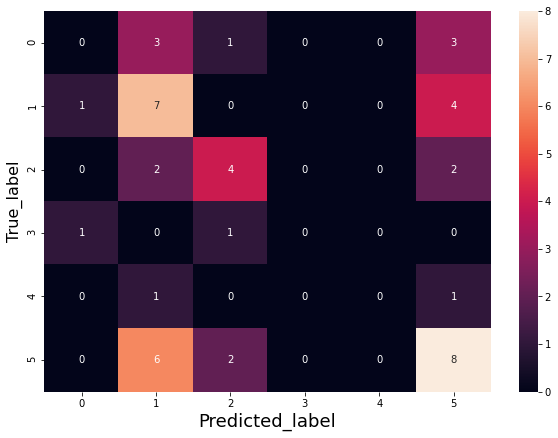

In [21]:
# Veiw confusion matrix of the the test data
from sklearn.metrics import confusion_matrix

matrix = confusion_matrix(test_Y.argmax(axis=1), Y_predict.argmax(axis=1))

#print(matrix)

df_cm = pd.DataFrame(matrix, index = [i for i in range(0,6)],
                  columns = [i for i in range(0,6)])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)
plt.xlabel('Predicted_label', fontsize=18)
plt.ylabel('True_label', fontsize=16)
#plt.savefig('Confusion_Matix/trainedon-lat_lon&rating&tag_tokens_activities.png')

In [179]:
tf.saved_model.save(model, 'question_field')

In [180]:
classification_model = tf.keras.models.load_model('question_field.h5', compile=False)

In [181]:
preds = classification_model.predict([train_encoded_question_types, train_actual_question_tokens, train_correct_statement_tokens])

In [182]:
for i in preds[:20]:
    max_index = np.argmax(i)
    print(classes[max_index])

Physics
Physics
General
Chemistry
Chemistry
Biology
Chemistry
Chemistry
Biology
Chemistry
Chemistry
Physics
Biology
Physics
Physics
Physics
Physics
Astronomy
Biology
Astronomy


In [192]:
import joblib as jl
from google.api_core.client_options import ClientOptions
import googleapiclient
import os

os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="thermal-works-298110-65274639ac90.json"

In [210]:
def tokenize_question(question_text):
    """Tokenize tags and add to dataframe

    # TODO: use a global to instantiate tokenizer
    
    """
    tokenizer = jl.load('artifacts/actual_question_tokenizer.bin')
    padded_tokens = []
    for tags in [question_text]:
        seqs = tokenizer.texts_to_sequences([tags])
        padded_seqs = tf.keras.preprocessing.sequence.pad_sequences(seqs, 15, padding='post')
        padded_tokens.append(padded_seqs)
        
    # update df
    #df_emb['tag_tokens'] = padded_tokens
    
    return padded_tokens[0]

def classify_question(question):
    actual_question = tokenize_question(question)
    #print(actual_question.tolist()[0])
    correct_statement = np.array([[50,6,77,100,123]])
    #print(correct_statement)
    encoded_question_type = np.array([[0,0,1,0]])
    #print(encoded_question_type)
    
    return [{"question_type_encoding":encoded_question_type.tolist()[0], "question_tokens":actual_question.tolist()[0], "correct_statment_tokens":correct_statement.tolist()[0]}]
    preds = classification_model.predict([encoded_question_type, actual_question, correct_statement])
    #print(preds)
    for i in preds:
        max_index = np.argmax(i)
        print(classes[max_index])

In [211]:
classify_question('earth quakes can cause tsunamis')

[{'question_type_encoding': [0, 0, 1, 0],
  'question_tokens': [59, 12, 228, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  'correct_statment_tokens': [50, 6, 77, 100, 123]}]

In [212]:
# Create the AI Platform service object.
# To authenticate set the environment variable
# GOOGLE_APPLICATION_CREDENTIALS=<path_to_service_account_file>
endpoint = 'https://europe-west1-ml.googleapis.com'
client_options = ClientOptions(api_endpoint=endpoint)
service = googleapiclient.discovery.build('ml', 'v1', client_options=client_options)


def predict_json(project, model, instances, version=None):
    """Send json data to a deployed model for prediction.

    Args:
        project (str): project where the AI Platform Model is deployed.
        model (str): model name.
        instances ([Mapping[str: Any]]): Keys should be the names of Tensors
            your deployed model expects as inputs. Values should be datatypes
            convertible to Tensors, or (potentially nested) lists of datatypes
            convertible to tensors.
        version: str, version of the model to target.
    Returns:
        Mapping[str: any]: dictionary of prediction results defined by the
            model.
    """
    name = 'projects/{}/models/{}'.format(project, model)

    if version is not None:
        name += '/versions/{}'.format(version)

    response = service.projects().predict(
        name=name,
        body={'instances': instances}
    ).execute()

    if 'error' in response:
        raise RuntimeError(response['error'])

    return response['predictions']

In [216]:
instances = classify_question('Our body has 11 organ systems')

preds = predict_json('thermal-works-298110', 'guess_the_field', instances, version='which_field')

for i in preds:
    max_index = np.argmax(i)
    print(classes[max_index])

Physics
